Team - 4

M Praveen             - CS20B1023

V Hemanth Kumar       - EC20B1005

D Sreenivasulu Reddy  - EC20B1061

In [75]:
import os
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

## constants or Parameters

In [76]:
# Define constants
NYQUIST_FREQ = 500
LOWCUT_FREQ = 20
HIGHCUT_FREQ = 250
FATIGUE_RMS_THRESHOLD = 0.15
FATIGUE_MF_THRESHOLD = 50

## Reading the dataset

In [77]:
all_signal = []
meta_data = []
for file in sorted(os.listdir("sEMG walk\\sEMG\\")):
    if file.endswith(".dat"):
        signals, fields= wfdb.rdsamp("sEMG walk\\sEMG\\" + os.path.splitext(file)[0])
        all_signal.append(signals)
        meta_data.append(fields)

## Plotting the types of signal taken from a single person

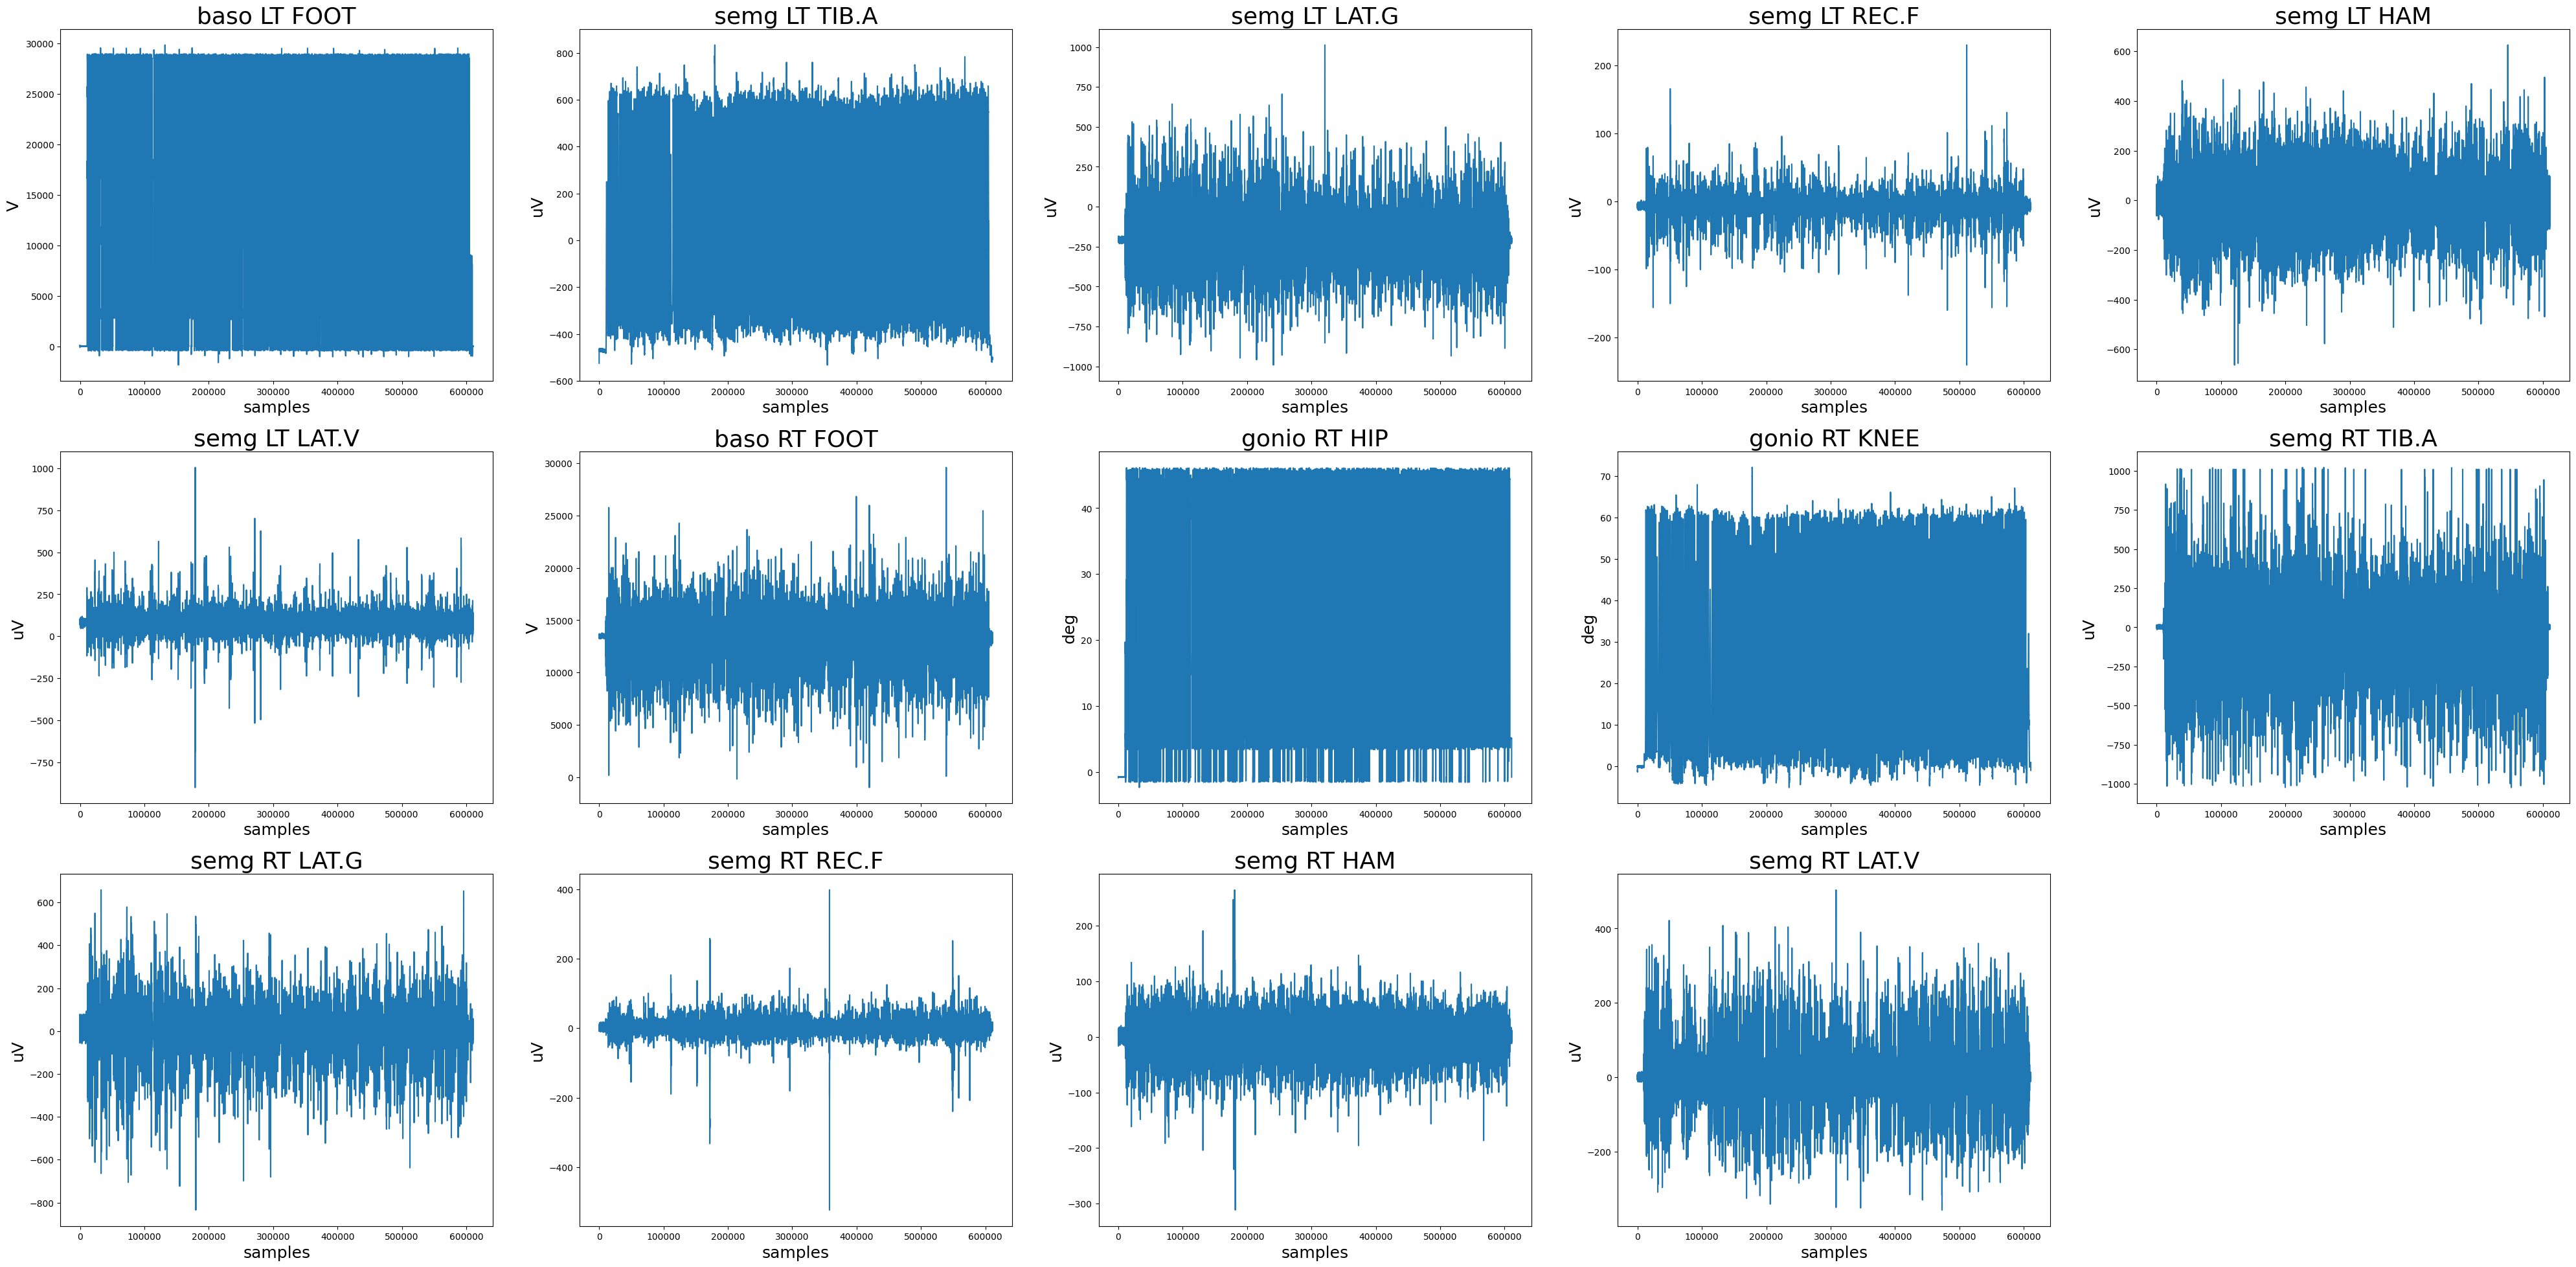

In [78]:
plt.figure(figsize=(50, 24))
for i in range(all_signal[0].shape[1]):
    plt.subplot(3,5, i + 1)
    plt.ylabel(meta_data[0]['units'][i], fontsize=18)
    plt.xlabel('samples', fontsize=18)
    plt.plot(all_signal[0].T[i])
    plt.title(meta_data[0]['sig_name'][i], fontsize=26)

## Plot signals and spectral signals

In [79]:
def plot_signal(signal, fs):
    time = np.arange(len(signal)) / fs
    
    plt.plot(time, signal)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

In [80]:
def plot_spectrum(freqs, psd):
    plt.plot(freqs, psd)
    plt.xlabel('frequency')
    plt.ylabel('Power Spectral Density')
    plt.show()

## Function to filter EMG signal

In [81]:
def filter_emg(signal, lowcut, highcut, fs):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    b, a = butter(4, [low, high], btype='band')

    return filtfilt(b, a, signal)

## Function to detect fatigue

In [82]:
def detect_fatigue(emg_signal, fs):

    emg_filt = filter_emg(emg_signal, LOWCUT_FREQ, HIGHCUT_FREQ, fs)

    emg_rms = np.sqrt(np.mean(np.square(emg_filt)))

    emg_rms *= 25 / 100

    freqs, psd = welch(emg_filt, fs=fs, nperseg=512)

    # plot_signal(emg_filt, fs)
    # plot_spectrum(freqs, psd)

    cumulative_power = np.cumsum(psd)
    median_power = cumulative_power[-1] / 2
    median_frequency_idx = np.argmin(np.abs(cumulative_power - median_power))
    median_frequency = freqs[median_frequency_idx]
    
    
    print(f'RMS value = {round(emg_rms,2)}')
    print(f'Median Frequency = {round(median_frequency, 2)}')

    if emg_rms > FATIGUE_RMS_THRESHOLD and median_frequency < FATIGUE_MF_THRESHOLD:
        return emg_rms, median_frequency, 4
    else:
        return emg_rms, median_frequency, 5

## Main function

In [83]:
fs = NYQUIST_FREQ * 2
X = []
y = []
for i in range(all_signal[0].shape[1]):
    rms, mf, state = detect_fatigue(all_signal[0].T[i], fs)
    X.append([rms, mf])
    if state == 4:
        print('Muscle fatigue detected.\n')
        y.append(1)

    elif state == 5:
        print('Muscle fatigue not detected.\n')
        y.append(0)

RMS value = 201.96
Median Frequency = 39.06
Muscle fatigue detected.

RMS value = 0.36
Median Frequency = 68.36
Muscle fatigue not detected.

RMS value = 15.53
Median Frequency = 46.88
Muscle fatigue detected.

RMS value = 1.36
Median Frequency = 46.88
Muscle fatigue detected.

RMS value = 10.73
Median Frequency = 48.83
Muscle fatigue detected.

RMS value = 5.43
Median Frequency = 42.97
Muscle fatigue detected.

RMS value = 183.76
Median Frequency = 39.06
Muscle fatigue detected.

RMS value = 0.32
Median Frequency = 39.06
Muscle fatigue detected.

RMS value = 0.01
Median Frequency = 66.41
Muscle fatigue not detected.

RMS value = 20.31
Median Frequency = 58.59
Muscle fatigue not detected.

RMS value = 8.43
Median Frequency = 44.92
Muscle fatigue detected.

RMS value = 1.9
Median Frequency = 44.92
Muscle fatigue detected.

RMS value = 3.01
Median Frequency = 42.97
Muscle fatigue detected.

RMS value = 6.71
Median Frequency = 37.11
Muscle fatigue detected.



## Training the Machine Learning Model 

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy: .2f}, Precision: {precision: .2f}, Recall: {recall: .2f}, F1-score: {f1: .2f}')

Accuracy:  0.86, Precision:  0.83, Recall:  1.00, F1-score:  0.91
